In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


## Prophet

Prophet is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers.

That's all to say that if you give Prophet historical data, it will attempt to extrapolate into the future for you.

Installing Prophet on to your machine is a bit more involved, but the [README](https://github.com/facebook/prophet#installation-in-python) is incredibly detailed...

## Purchases

In order to demonstrate how Prophet works, we need some historical data.  I thought it would be fun to use some of my own personal data.

The `purchases.csv` file, contains all of my Amazon purchases since 2012. It has 83 rows and two columns (date and amount spent). 

Loading up pandas and the purchases data:

In [2]:
import pandas as pd
purchases = pd.read_csv('data/purchases.csv')

We can see that I spent `$17.99` on 2018-01-07 and `$158.19` on 2018-01-31:

In [3]:
print(purchases.tail())

          date  amount
78  2017-12-24   62.53
79  2017-12-27   43.99
80  2017-12-28   21.99
81  2018-01-07   17.99
82  2018-01-31  158.19


Rolling the values into a running total can be accomplished with:

In [4]:
purchases['cumsum'] = purchases['amount'].cumsum()
print(purchases.tail())
purchases.info()

          date  amount   cumsum
78  2017-12-24   62.53  4906.19
79  2017-12-27   43.99  4950.18
80  2017-12-28   21.99  4972.17
81  2018-01-07   17.99  4990.16
82  2018-01-31  158.19  5148.35
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    83 non-null     object 
 1   amount  83 non-null     float64
 2   cumsum  83 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.1+ KB


Disturbingly, I've spent a grand total of \$5148.35 on Amazon since 2012...

## Forecast

In order to forecast with Prophet we need to massage the purchases `DataFrame` to conform to a specific input structure. Prophet inputs are always a `DataFrame` with two columns: ds and y. The `ds` (datestamp) column must contain a date and the `y` column must be numeric, and represents the measurement we want to forecast:

In [5]:
type(purchases["cumsum"][0])

numpy.float64

In [6]:
purchases = purchases[['date', 'cumsum']]
purchases.columns = ['ds', 'y']
print(purchases.head())


           ds       y
0  2012-07-25   82.55
1  2012-12-10  143.56
2  2013-02-19  155.10
3  2013-02-24  221.77
4  2013-04-20  229.76


Let's import Prophet:

In [7]:
from fbprophet import Prophet

Instantiate an instance of the Prophet class and fit it to the purchases data:

In [8]:
m = Prophet(daily_seasonality=False)
m.fit(purchases)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In order to forecast values one year into the future we need to use the `.make_future_dataframe` method with periods argument set to 365:

In [9]:
future = m.make_future_dataframe(periods=365)
print(future.tail())

            ds
443 2019-01-27
444 2019-01-28
445 2019-01-29
446 2019-01-30
447 2019-01-31


Predicting my total spending on Amazon through 2018 and into 2019 is now dead simple. We just have to call the `predict`  method on top of the future `DataFrame` that we created above:

In [10]:
forecast = m.predict(future)

Inspecting the forecast object:

In [11]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
443,2019-01-27,7865.047372,7650.467496,8118.886205
444,2019-01-28,7833.884062,7604.002481,8084.385498
445,2019-01-29,7828.956005,7607.120121,8080.378541
446,2019-01-30,7878.670103,7654.141739,8113.607864
447,2019-01-31,7934.337342,7711.840348,8180.558364


We can see that I am meant to spend a cumulative total of \$7985 (yhat) on Amazon. But now that I know that I'm keen to ratchet back my spending!

## Visualize

Prophet comes packaged with a really great `plot` convenience method. Running it on top of the `m` object we can get a better sense of the trend:

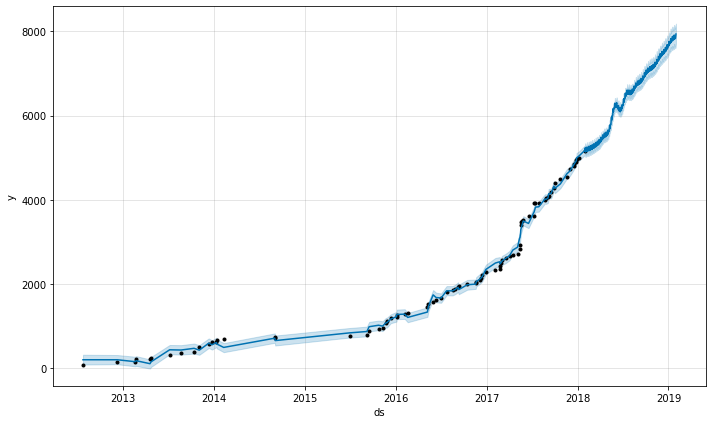

In [12]:
pd.plotting.register_matplotlib_converters()
# known issue in pandas right now
# github issue: https://github.com/facebook/prophet/issues/999

m.plot(forecast);

The library also includes a `plot_components` method that prints panels for trend, weekly and yearly seasonalities if present:

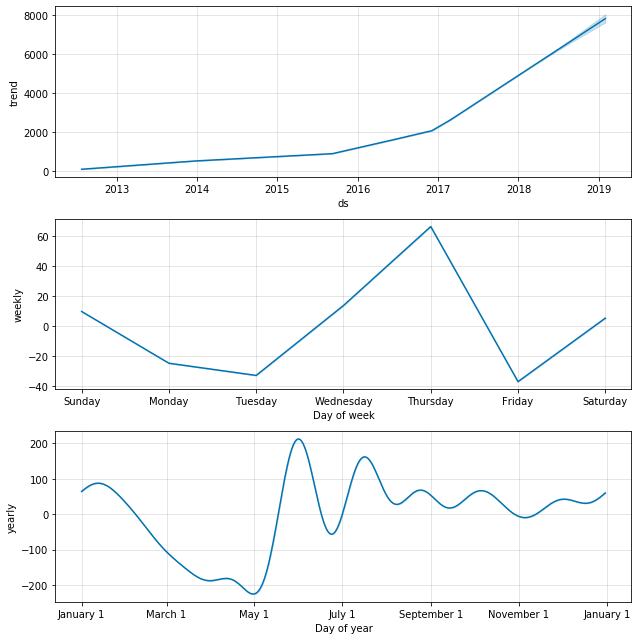

In [13]:
m.plot_components(forecast);